Raw dataset shape: (427625, 25)
Classes: [0 1 2 3] | num_classes: 4

==== GNN (Single) — Train/Test 60/40 — scaler=standard — Oversampler=ADASYN ====
After oversampling: (806664, 23) note: ADASYN
Epoch 1/2
10714/10714 ━━━━━━━━━━━━━━━━━━━━ 329s 29ms/step - accuracy: 0.6598 - loss: 0.8712 - val_accuracy: 0.6893 - val_loss: 1.2498
Epoch 2/2
10714/10714 ━━━━━━━━━━━━━━━━━━━━ 326s 30ms/step - accuracy: 0.7361 - loss: 0.7147 - val_accuracy: 0.7283 - val_loss: 0.9430


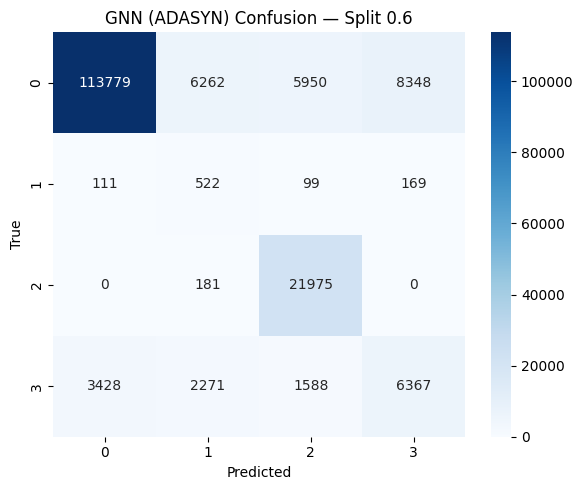

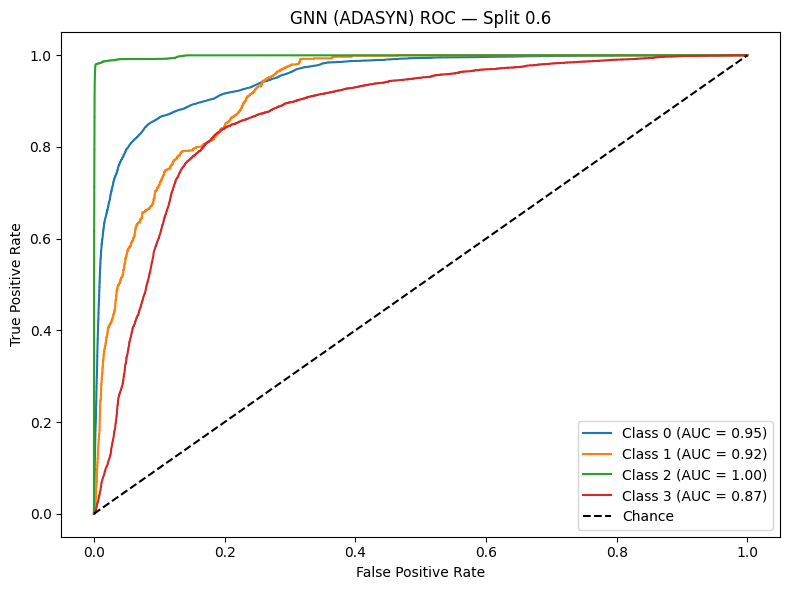

Metrics: {'train_ratio': 0.6, 'train_shape': '(256575, 23)', 'train_after_adasyn': '(806664, 23)', 'oversampler_note': 'ADASYN', 'accuracy': 0.8339, 'precision_weighted': 0.8923, 'recall_weighted': 0.8339, 'f1_weighted': 0.8563, 'roc_auc': 0.9359, 'train_time_sec': 655.872, 'ram_used_mb': 0.0, 'ram_peak_mb': 984.59}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90    134339
           1       0.06      0.58      0.10       901
           2       0.74      0.99      0.85     22156
           3       0.43      0.47      0.45     13654

    accuracy                           0.83    171050
   macro avg       0.55      0.72      0.58    171050
weighted avg       0.89      0.83      0.86    171050


==== GNN (Single) — Train/Test 70/30 — scaler=standard — Oversampler=ADASYN ====
After oversampling: (940258, 23) note: ADASYN
Epoch 1/2
12488/12488 ━━━━━━━━━━━━━━━━━━━━ 300s 24ms/step - accuracy: 0.6706 - loss: 0.8478 - v

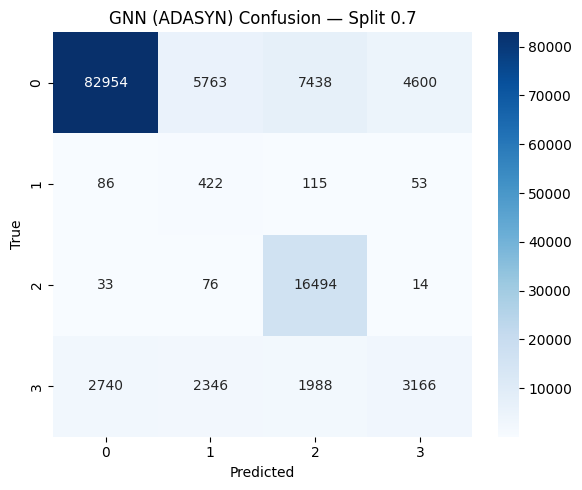

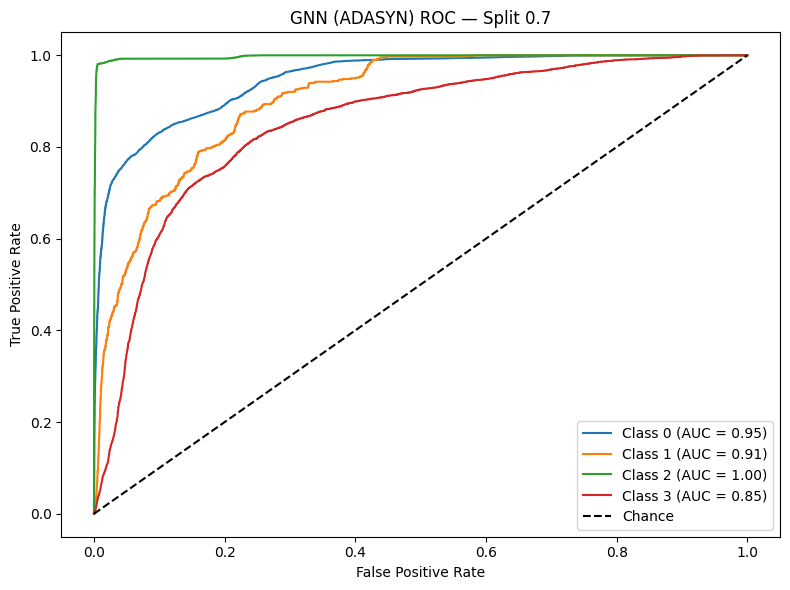

Metrics: {'train_ratio': 0.7, 'train_shape': '(299337, 23)', 'train_after_adasyn': '(940258, 23)', 'oversampler_note': 'ADASYN', 'accuracy': 0.8032, 'precision_weighted': 0.8738, 'recall_weighted': 0.8032, 'f1_weighted': 0.827, 'roc_auc': 0.925, 'train_time_sec': 630.178, 'ram_used_mb': 0.0, 'ram_peak_mb': 923.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89    100755
           1       0.05      0.62      0.09       676
           2       0.63      0.99      0.77     16617
           3       0.40      0.31      0.35     10240

    accuracy                           0.80    128288
   macro avg       0.51      0.69      0.53    128288
weighted avg       0.87      0.80      0.83    128288


==== GNN (Single) — Train/Test 80/19 — scaler=standard — Oversampler=ADASYN ====
After oversampling: (1074711, 23) note: ADASYN
Epoch 1/2
14274/14274 ━━━━━━━━━━━━━━━━━━━━ 608s 42ms/step - accuracy: 0.6790 - loss: 0.8285 - val

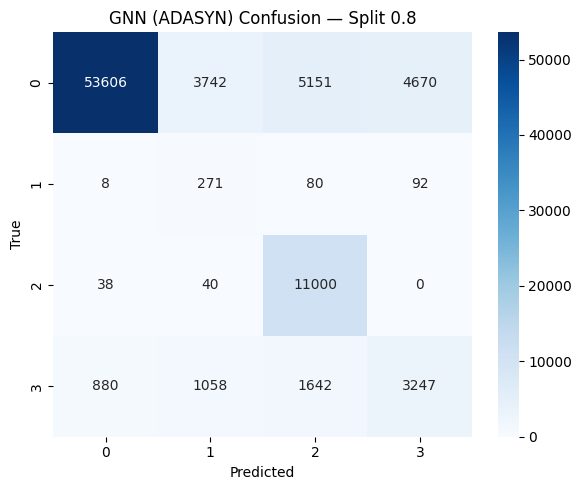

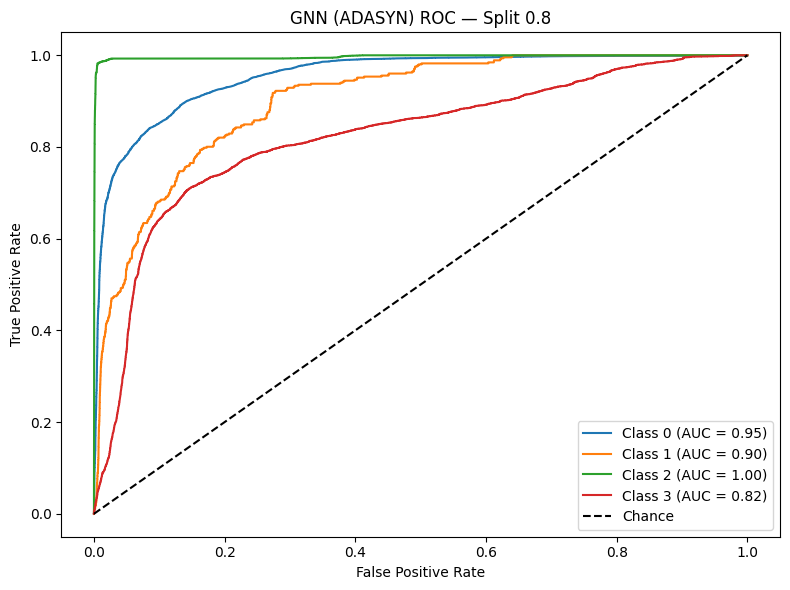

Metrics: {'train_ratio': 0.8, 'train_shape': '(342100, 23)', 'train_after_adasyn': '(1074711, 23)', 'oversampler_note': 'ADASYN', 'accuracy': 0.7965, 'precision_weighted': 0.8844, 'recall_weighted': 0.7965, 'f1_weighted': 0.8258, 'roc_auc': 0.9186, 'train_time_sec': 1068.514, 'ram_used_mb': 0.0, 'ram_peak_mb': 1178.16}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     67169
           1       0.05      0.60      0.10       451
           2       0.62      0.99      0.76     11078
           3       0.41      0.48      0.44      6827

    accuracy                           0.80     85525
   macro avg       0.51      0.72      0.54     85525
weighted avg       0.88      0.80      0.83     85525


✅ All ratios complete. Summary saved to: outputs_gnn_single_adasyn\metrics_summary_gnn_single_adasyn_standard.csv


In [ ]:
# ================== GNN (Single) · ADASYN (train-only) · 60/70/80 ==================
# - Oversampling with ADASYN on TRAIN ONLY (fallback to RandomOverSampler if ADASYN can't run).
# - Single GNN over a fixed "feature graph" (chain adjacency).
# - Tracks RAM used and peak RAM during training.
# - Saves Confusion Matrix & ROC curves per split, plus a CSV summary.

import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import psutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
)

# --- Oversampling (ADASYN + fallback ROS) ---
from imblearn.over_sampling import ADASYN, RandomOverSampler

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ================== CONFIG ==================
ALL_DATA = Path(r"C:\Users\deepa\OneDrive\Desktop\Research\GNN\ADASYN\all_three.csv")
OUT_DIR = Path("./outputs_gnn_single_adasyn"); OUT_DIR.mkdir(parents=True, exist_ok=True)
TARGET_COL = "label"
SEED = 42
EPOCHS = 2
BATCH_SIZE = 64
TRAIN_RATIOS = [0.6, 0.7, 0.8]
SCALER_NAME = "standard"  # decimal | minmax | robust | standard

np.random.seed(SEED)
tf.random.set_seed(SEED)

# ================== SCALERS & HELPERS ==================
class DecimalScaler:
    def fit(self, X):
        m = np.maximum(np.max(np.abs(X), axis=0), 1e-12)
        self.j_ = np.ceil(np.log10(m)).astype(np.float32)
        return self
    def transform(self, X):
        denom = (10.0 ** self.j_)
        return X / denom
    def fit_transform(self, X):
        return self.fit(X).transform(X)

def get_scaler(name):
    nm = name.lower()
    if nm == 'decimal': return DecimalScaler()
    if nm == 'minmax': return MinMaxScaler()
    if nm == 'robust': return RobustScaler(quantile_range=(25.0, 75.0))
    if nm == 'standard': return StandardScaler()
    raise ValueError('Unknown scaler: ' + str(name))

def apply_adasyn_safe(X, y):
    """
    Train-only oversampling with ADASYN.
    Fallback to RandomOverSampler if ADASYN can't run (e.g., too few minority samples).
    """
    try:
        counts = pd.Series(y).value_counts()
        if counts.min() < 2:
            ros = RandomOverSampler(random_state=SEED)
            return ros.fit_resample(X, y), 'RandomOverSampler(fallback: minority<2)'
        ada = ADASYN(random_state=SEED, n_neighbors=5)
        return ada.fit_resample(X, y), 'ADASYN'
    except Exception as e:
        ros = RandomOverSampler(random_state=SEED)
        return ros.fit_resample(X, y), f'ROS(fallback):{str(e)}'

def plot_confusion_matrix(cm, class_names, outpath, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()

def plot_roc(y_true, y_probs, class_names, outpath, title="ROC Curve"):
    try:
        y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
        plt.figure(figsize=(8, 6))
        for i, c in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {c} (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], "k--", label="Chance")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(outpath)
        plt.show()
    except Exception as e:
        print("ROC plotting failed:", e)

# -------- RAM tracking --------
def process_ram_mb():
    # Current process resident set size (RAM) in MB
    return psutil.Process(os.getpid()).memory_info().rss / (1024**2)

class RamTracker(callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.peak_mb = 0.0
    def on_epoch_end(self, epoch, logs=None):
        mb = process_ram_mb()
        if mb > self.peak_mb:
            self.peak_mb = mb

# ================== Graph Utilities (Feature-Chain) ==================
def make_chain_adjacency(n_features: int) -> np.ndarray:
    """Build symmetric normalized adjacency (A_hat = D^-1/2 (A+I) D^-1/2) for a chain over feature indices."""
    A = np.zeros((n_features, n_features), dtype=np.float32)
    for i in range(n_features - 1):
        A[i, i + 1] = 1.0
        A[i + 1, i] = 1.0
    A += np.eye(n_features, dtype=np.float32)
    deg = A.sum(axis=1)
    d_isqrt = 1.0 / np.sqrt(np.maximum(deg, 1e-12))
    A_norm = (d_isqrt[:, None] * A) * d_isqrt[None, :]
    return A_norm

class FixedGraphConv(layers.Layer):
    """
    Simple GCN layer with a fixed (precomputed) normalized adjacency A (N x N).
    Computes: activation( A @ X @ W + b )
    X: (batch, N, F_in), W: (F_in, F_out), A: (N, N)
    """
    def __init__(self, units, A_norm, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.units = int(units)
        self.A = tf.constant(A_norm, dtype=tf.float32)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        f_in = int(input_shape[-1])
        self.W = self.add_weight(
            shape=(f_in, self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="W"
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="b"
        )
        super().build(input_shape)

    def call(self, x):
        ax = tf.einsum('ij,bjf->bif', self.A, x)             # (batch, N, F_in)
        out = tf.einsum('bif,fh->bih', ax, self.W) + self.b  # (batch, N, F_out)
        return self.activation(out) if self.activation is not None else out

def build_gnn_single(n_features: int, num_classes: int, A_norm: np.ndarray) -> tf.keras.Model:
    X_in = layers.Input(shape=(n_features, 1))

    g = FixedGraphConv(64, A_norm, activation='relu')(X_in)
    g = layers.BatchNormalization()(g)
    g = layers.Dropout(0.25)(g)

    g = FixedGraphConv(64, A_norm, activation='relu')(g)
    g = layers.Dropout(0.25)(g)

    g = layers.GlobalAveragePooling1D()(g)
    out = layers.Dense(num_classes, activation='softmax')(g)

    m = models.Model(X_in, out)
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

# ================== LOAD & PREPROCESS DATA ==================
df = pd.read_csv(ALL_DATA)
print("Raw dataset shape:", df.shape)
df = df.dropna(subset=[TARGET_COL])
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

X_features = df.drop(columns=[TARGET_COL]).apply(pd.to_numeric, errors='coerce')
y_labels = df[TARGET_COL].values

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_features)

le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)
classes = np.unique(y_encoded)
num_classes = len(classes)
print("Classes:", classes, "| num_classes:", num_classes)

n_features = X_imputed.shape[1]
A_norm = make_chain_adjacency(n_features)

# ================== RUN FOR EACH RATIO (60/70/80) ==================
results = []

for ratio in TRAIN_RATIOS:
    print(f"\n==== GNN (Single) — Train/Test {int(ratio*100)}/{int((1-ratio)*100)} — scaler={SCALER_NAME} — Oversampler=ADASYN ====")

    # Split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_imputed, y_encoded, train_size=ratio, stratify=y_encoded, random_state=SEED
    )

    # Scale
    scaler = get_scaler(SCALER_NAME)
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # ADASYN (train-only)
    (X_tr_res, y_tr_res), over_note = apply_adasyn_safe(X_tr_s, y_tr)
    print('After oversampling:', X_tr_res.shape, 'note:', over_note)

    # Reshape to (batch, N_nodes(features), F_node=1)
    X_train_model = X_tr_res.reshape((-1, n_features, 1)).astype('float32')
    X_test_model  = X_te_s.reshape((-1, n_features, 1)).astype('float32')

    # Build & Train GNN (Single)
    model = build_gnn_single(n_features, num_classes, A_norm)

    ram_cb = RamTracker()                 # track peak RAM per epoch
    ram_before = process_ram_mb()         # RAM before training

    t0 = time.time()
    history = model.fit(
        X_train_model, y_tr_res,
        validation_split=0.15,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=[ram_cb]
    )
    train_time = time.time() - t0

    ram_after = process_ram_mb()          # RAM after training
    ram_used_mb = max(0.0, ram_after - ram_before)
    ram_peak_mb = ram_cb.peak_mb          # absolute peak observed at epoch ends

    # Predict
    probs = model.predict(X_test_model, verbose=0)  # (n_test, num_classes)
    preds = np.argmax(probs, axis=1)

    # ================== METRICS ==================
    acc = accuracy_score(y_te, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, preds, average='weighted', zero_division=0)

    # ROC-AUC: handle binary vs multi-class robustly
    if num_classes == 2:
        roc = roc_auc_score(y_te, probs[:, 1])
    else:
        roc = roc_auc_score(y_te, probs, multi_class="ovr")

    # Confusion Matrix
    cm = confusion_matrix(y_te, preds)
    cm_path = OUT_DIR / f'confusion_gnn_single_adasyn_{SCALER_NAME}_split{int(ratio*100)}.png'
    plot_confusion_matrix(cm, [str(c) for c in classes], outpath=cm_path, title=f'GNN (ADASYN) Confusion — Split {ratio}')

    # ROC Curve
    roc_path = OUT_DIR / f'roc_gnn_single_adasyn_{SCALER_NAME}_split{int(ratio*100)}.png'
    plot_roc(y_te, probs, list(classes), outpath=roc_path, title=f'GNN (ADASYN) ROC — Split {ratio}')

    metrics = {
        'train_ratio': ratio,
        'train_shape': str(X_tr.shape),
        'train_after_adasyn': str(X_tr_res.shape),
        'oversampler_note': over_note,
        'accuracy': round(float(acc), 4),
        'precision_weighted': round(float(prec), 4),
        'recall_weighted': round(float(rec), 4),
        'f1_weighted': round(float(f1), 4),
        'roc_auc': round(float(roc), 4),
        'train_time_sec': round(float(train_time), 3),
        'ram_used_mb': round(float(ram_used_mb), 2),   # ✅ added
        'ram_peak_mb': round(float(ram_peak_mb), 2)    # ✅ added (optional but useful)
    }
    results.append(metrics)
    print('Metrics:', metrics)

    print("\nClassification Report:")
    print(classification_report(y_te, preds, digits=2))

# ================== SAVE RESULTS ==================
df_res = pd.DataFrame(results)
csv_out = OUT_DIR / f'metrics_summary_gnn_single_adasyn_{SCALER_NAME}.csv'
df_res.to_csv(csv_out, index=False)
print(f"\n✅ All ratios complete. Summary saved to: {csv_out}")
